# Предсказание цен в Airbnb
Скриншоты карт можно посмотреть в папке "plots/airbnb"
для просмотра карт нужно: pip3 install ipyleaflet


In [49]:
from math import sqrt
import pandas as pd
import seaborn as sns
from ipyleaflet import *
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from ipywidgets import HTML




from sklearn import preprocessing
from scipy.spatial import distance


In [2]:
data_file = "../csv/airbnb/air_bnb.csv"
dataset = pd.read_csv(data_file)
for feature in "id, name, host_id, host_name, last_review".split(", "):
    dataset.drop(feature,inplace=True, axis=1)
dataset.describe(percentiles=[0.05, 0.95])



,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
5%,40.646114,-74.003880,40.000000,1.000000,0.000000,0.040000,1.000000,0.000000
50%,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
95%,40.825643,-73.865771,355.000000,30.000000,114.000000,4.640000,15.000000,359.000000
max,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


In [3]:
dataset.sort_values(by='price',ascending=False).head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
9151,Queens,Astoria,40.76810,-73.91651,Private room,10000,100,2,0.04,1,0
17692,Brooklyn,Greenpoint,40.73260,-73.95739,Entire home/apt,10000,5,5,0.16,1,0
29238,Manhattan,Upper West Side,40.77213,-73.98665,Entire home/apt,10000,30,0,NaN,1,83
40433,Manhattan,Lower East Side,40.71980,-73.98566,Entire home/apt,9999,30,0,NaN,1,365
12342,Manhattan,Lower East Side,40.71355,-73.98507,Private room,9999,99,6,0.14,1,83


## Посмотрим в каких колонках есть пропуски

In [4]:
dataset.isna().any()

neighbourhood_group               False
neighbourhood                     False
latitude                          False
longitude                         False
room_type                         False
price                             False
minimum_nights                    False
number_of_reviews                 False
reviews_per_month                  True
calculated_host_listings_count    False
availability_365                  False
dtype: bool

## Заполним пропуски нулями

In [5]:
dataset['reviews_per_month'].fillna(0,inplace=True)

In [6]:
dataset.isna().any()

neighbourhood_group               False
neighbourhood                     False
latitude                          False
longitude                         False
room_type                         False
price                             False
minimum_nights                    False
number_of_reviews                 False
reviews_per_month                 False
calculated_host_listings_count    False
availability_365                  False
dtype: bool

## Посмотрим на распредление цен

<AxesSubplot:ylabel='Frequency'>

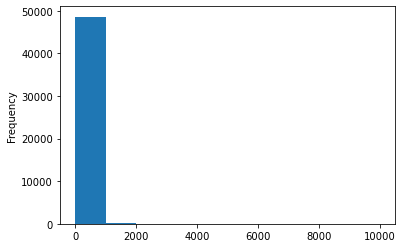

In [7]:
dataset['price'].plot.hist()

## Видно, что у нас цены распределены не равномерно, попробуем удалить 5% самых дешевых и 5% самых дорогих 

<AxesSubplot:ylabel='Frequency'>

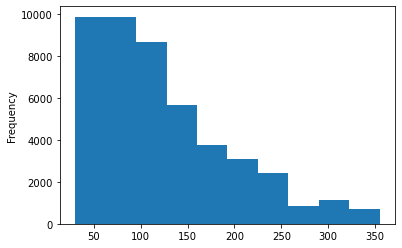

In [8]:
dataset.drop(dataset[dataset['price'] > 355.0].index, inplace=True)
dataset.drop(dataset[dataset['price'] < 30.0].index, inplace=True)
dataset['price'].plot.hist()

In [11]:
dataset.describe(percentiles=[0.999,0.01])

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,46050.000000,46050.000000,46050.000000,46050.000000,46050.000000,46050.000000,46050.00000,46050.000000
mean,40.728674,-73.951207,123.451531,6.933920,23.887970,1.104862,6.70317,109.664017
std,0.054944,0.046207,71.698972,19.874165,45.271781,1.610611,31.24684,130.376280
min,40.499790,-74.244420,30.000000,1.000000,0.000000,0.000000,1.00000,0.000000
1%,40.596815,-74.027636,33.000000,1.000000,0.000000,0.000000,1.00000,0.000000
50%,40.722110,-73.954730,100.000000,2.000000,5.000000,0.380000,1.00000,40.000000
99.9%,40.893926,-73.731367,350.000000,300.000000,384.755000,11.169510,327.00000,365.000000
max,40.913060,-73.712990,355.000000,1250.000000,629.000000,58.500000,327.00000,365.000000


##  Посмотрим где расположены самые дорогие аппартаменты

In [50]:
a = Map(center=(40.7072,-73.9909), zoom = 10)
mean_price = dataset['price'].mean()
for index, row in dataset.iterrows():
    if row['price'] >= 355:
        message = HTML()
        message.value = "Longitude: {0}, latitude: {1}".format(row['longitude'], row['latitude']) 
        marker = Marker(location=(row['latitude'], row['longitude']), draggable=False)
        marker.popup = message
        a.add_layer(marker)
a

Map(center=[40.7072, -73.9909], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'z…

##  Посмотрим где расположены самые дешевые аппартаменты

In [14]:
a = Map(center=(40.7072,-73.9909), zoom = 10)
mean_price = dataset['price'].mean()
for index, row in dataset.iterrows():
    if row['price'] <= 30 and row['price'] > 0:
        a.add_layer(Marker(location=(row['latitude'], row['longitude']),draggable=False))
a

Map(center=[40.7072, -73.9909], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'z…

##  Построим Heatmap

In [15]:

a = Map(center=(40.7072,-73.9909), zoom = 10)

markers = []
heat_coef = 1/100

for index, row in dataset.iterrows():
    markers.append([row['latitude'], row['longitude'], row['price'] * heat_coef]) 
heatmap = Heatmap(locations=markers, radius=10)
a.add_layer(heatmap)
a

Map(center=[40.7072, -73.9909], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'z…

# А теперь посмотрим где расположены  5% самых дорогих аппартамментов

In [16]:
dataset.describe(percentiles=[0.95,0.05])

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,46050.000000,46050.000000,46050.000000,46050.000000,46050.000000,46050.000000,46050.00000,46050.000000
mean,40.728674,-73.951207,123.451531,6.933920,23.887970,1.104862,6.70317,109.664017
std,0.054944,0.046207,71.698972,19.874165,45.271781,1.610611,31.24684,130.376280
min,40.499790,-74.244420,30.000000,1.000000,0.000000,0.000000,1.00000,0.000000
5%,40.645800,-74.003250,40.000000,1.000000,0.000000,0.000000,1.00000,0.000000
50%,40.722110,-73.954730,100.000000,2.000000,5.000000,0.380000,1.00000,40.000000
95%,40.826085,-73.864253,275.000000,30.000000,116.000000,4.350000,13.00000,358.000000
max,40.913060,-73.712990,355.000000,1250.000000,629.000000,58.500000,327.00000,365.000000


In [17]:
a = Map(center=(40.7072,-73.9909), zoom = 10)

markers = []
heat_coef = 1/100
percentile_95_price = 275.0

for index, row in dataset.iterrows():
    if row['price'] < percentile_95_price:
        continue
    markers.append([row['latitude'], row['longitude'], row['price'] * heat_coef]) 
heatmap = Heatmap(locations=markers, radius=10)
a.add_layer(heatmap)
a

Map(center=[40.7072, -73.9909], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'z…

## Видно, что скопление дорогих аппартаментов находится на юге Central Park и на западном берегу. Возьмем точку посередине и будет от нее отсчитывать расстояние.

In [51]:
cent_lon = 40.72205
cent_lat = -74.00121
cent = (cent_lon, cent_lat)
dataset['relative_dist'] = np.array(list(distance.euclidean(cent, (row['longitude'],row['latitude'])) 
                                    for index, row in dataset.iterrows()))

In [52]:
dataset.sort_values(by='relative_dist',ascending=False).head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,relative_dist
23011,Bronx,North Riverdale,40.91169,-73.90564,Private room,50,365,0,0.00,1,363,162.309833
25308,Bronx,North Riverdale,40.90734,-73.90137,Private room,119,3,0,0.00,1,0,162.303738
3349,Bronx,North Riverdale,40.90804,-73.90005,Private room,53,2,143,2.13,1,263,162.303301
48033,Bronx,North Riverdale,40.91167,-73.89566,Private room,40,1,1,1.00,3,174,162.302771
14715,Bronx,Riverdale,40.90080,-73.90639,Private room,49,6,2,0.05,1,340,162.302653


## Попробуем построить простую линейную регрессию, преобразовав строковые значения в булевы(dummies)

In [53]:
dummies = pd.get_dummies(data=dataset, columns=['room_type', 'neighbourhood', 
                                                'neighbourhood_group'])

In [54]:
y = dummies['price']

dummies.drop(columns=['price','latitude', 'longitude'], inplace=True)
dummies.describe()

,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,relative_dist,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,neighbourhood_Allerton,...,neighbourhood_Willowbrook,neighbourhood_Windsor Terrace,neighbourhood_Woodhaven,neighbourhood_Woodlawn,neighbourhood_Woodside,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island
count,46050.000000,46050.000000,46050.000000,46050.00000,46050.000000,46050.000000,46050.000000,46050.000000,46050.000000,46050.000000,...,46050.000000,46050.000000,46050.000000,46050.000000,46050.000000,46050.000000,46050.000000,46050.000000,46050.000000,46050.000000
mean,6.933920,23.887970,1.104862,6.70317,109.664017,162.212530,0.504669,0.474376,0.020955,0.000890,...,0.000022,0.003301,0.001868,0.000217,0.004995,0.022085,0.420217,0.430445,0.119522,0.007731
std,19.874165,45.271781,1.610611,31.24684,130.376280,0.048559,0.499984,0.499348,0.143237,0.029826,...,0.004660,0.057358,0.043175,0.014735,0.070496,0.146961,0.493599,0.495144,0.324406,0.087585
min,1.000000,0.000000,0.000000,1.00000,0.000000,161.967426,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.050000,1.00000,0.000000,162.179129,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,5.000000,0.380000,1.00000,40.000000,162.214744,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5.000000,24.000000,1.610000,2.00000,217.000000,162.250586,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
max,1250.000000,629.000000,58.500000,327.00000,365.000000,162.309833,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [55]:

X_train, X_test, y_train, y_test = train_test_split(dummies, y, test_size=0.33,
                                                        random_state=42)

scaler = StandardScaler()
reg = LinearRegression()
pipe = Pipeline([('scaler', scaler), ('reg', reg)])
pipe.fit(X_train, y_train)
print("Линейная регрессия:")
print("\tПравильность на обучающем наборе: {:.2f}".format(pipe.score(X_train, y_train)))
print("\tПравильность на тестовом наборе: {:.2f}".format(pipe.score(X_test, y_test)))

reg = Ridge(alpha=0.01)
pipe = Pipeline([('scaler', scaler), ('reg', reg)])
pipe.fit(X_train, y_train)
print("Гребневая регрессия:")
print("\tПравильность на обучающем наборе: {:.2f}".format(pipe.score(X_train, y_train)))
print("\tПравильность на тестовом наборе: {:.2f}".format(pipe.score(X_test, y_test)))

reg = Lasso(alpha=0.1)
pipe = Pipeline([('scaler', scaler), ('reg', reg)])
pipe.fit(X_train, y_train)
print("Лассо:")
print("\tПравильность на обучающем наборе: {:.2f}".format(pipe.score(X_train, y_train)))
print("\tПравильность на тестовом наборе: {:.2f}".format(pipe.score(X_test, y_test)))

reg = ElasticNet(alpha=0.5)
pipe = Pipeline([('scaler', scaler), ('reg', reg)])
pipe.fit(X_train, y_train)
print("ElasticNet:")
print("\tПравильность на обучающем наборе: {:.2f}".format(pipe.score(X_train, y_train)))
print("\tПравильность на тестовом наборе: {:.2f}".format(pipe.score(X_test, y_test)))

Линейная регрессия:
	Правильность на обучающем наборе: 0.51
	Правильность на тестовом наборе: -970322523245977403392.00
Гребневая регрессия:
	Правильность на обучающем наборе: 0.51
	Правильность на тестовом наборе: 0.51
Лассо:
	Правильность на обучающем наборе: 0.51
	Правильность на тестовом наборе: 0.51
ElasticNet:
	Правильность на обучающем наборе: 0.50
	Правильность на тестовом наборе: 0.50


## Уже не плохо, хотя линейная регрессия показывает плохой результат. Из Robust, Standart и MinMaxScaler лучший результат показывает Standart, хотя разница между ними в 2-4%. Ниже видно что искуственный признак особого вклада не вносит.

In [56]:
X_train, X_test, y_train, y_test = train_test_split(dummies.drop(columns='relative_dist'), y, test_size=0.3,
                                                        random_state=42)

reg = Ridge(alpha=0.01)
pipe = Pipeline([('scaler', scaler), ('reg', reg)])
pipe.fit(X_train, y_train)
print("Гребневая регрессия:")
print("\tПравильность на обучающем наборе: {:.2f}".format(pipe.score(X_train, y_train)))
print("\tПравильность на тестовом наборе: {:.2f}".format(pipe.score(X_test, y_test)))

Гребневая регрессия:
	Правильность на обучающем наборе: 0.51
	Правильность на тестовом наборе: 0.51
